# import data

In [1]:
import platform
import pandas as pd
from datetime import datetime, timedelta, time
ohlcv_data = pd.read_pickle('/Users/bokie/code/python/CMS/可转债套利/cms/stock_data_min.pkl')
print(ohlcv_data.keys())
for k,v in ohlcv_data.items():
    print(k,' data length: ',len(v))

dict_keys(['123046.SZ', '300587.SZ', '113642.SH', '603185.SH', '110061.SH', '600674.SH', '128081.SZ', '002203.SZ'])
123046.SZ  data length:  24684
300587.SZ  data length:  24684
113642.SH  data length:  19844
603185.SH  data length:  24684
110061.SH  data length:  24684
600674.SH  data length:  24684
128081.SZ  data length:  24684
002203.SZ  data length:  24684


# bond-stock pair

In [2]:
cbond_pair = ['128081.SZ','002203.SZ']
# cbond_pair = ['123046.SZ','300587.SZ']
# cbond_pair = ['110061.SH','600674.SH']
# cbond_pair = ['113642.SH','603185.SH']

In [3]:
cbond_pair_price = pd.DataFrame([])
cbond_pair_price = pd.concat([ohlcv_data[cbond_pair[0]]['close'],ohlcv_data[cbond_pair[1]]['close']],axis=1)
cbond_pair_price.columns = cbond_pair
cbond_pair_price = cbond_pair_price.dropna()
cbond_pair_price = cbond_pair_price.loc['2022-03-07 15:00:00':]
# cbond_pair_price.to_excel('cbond_pair_price.xlsx')
# cbond_pair_price.to_csv('cbond_pair_price.csv')

In [4]:
print(len(cbond_pair_price))
cbond_pair_price.head(10)

23246


,128081.SZ,002203.SZ
2022-03-07 15:00:00,125.675,43.392708
2022-03-08 09:30:00,126.001,43.580718
2022-03-08 09:31:00,125.809,43.430310
2022-03-08 09:32:00,125.519,43.279902
2022-03-08 09:33:00,125.280,43.129494
2022-03-08 09:34:00,125.226,43.091892
2022-03-08 09:35:00,124.995,43.091892
2022-03-08 09:36:00,124.647,43.054290
2022-03-08 09:37:00,124.294,43.167096
2022-03-08 09:38:00,123.900,43.016688


# signal calculate

先算cbond_return(日内收益率，相对于昨日收盘价)，再算cbond_position，计算cbond_position中用到的open_threshold和close_threshold分别是价格止盈价格止损信号。时间止损信号则是，每日15点时强制平仓

In [5]:
cbond_return = pd.DataFrame([])

cbond_preclose = cbond_pair_price.iloc[0,0] # 初始时刻的bond前收盘价
stock_preclose = cbond_pair_price.iloc[0,1] # 初始时刻的stock前收盘价

for index,row in cbond_pair_price.iterrows():
    
    cbond_return.loc[index,cbond_pair[0]] = row[cbond_pair[0]]/cbond_preclose - 1 # 算日内的return
    cbond_return.loc[index,cbond_pair[1]] = row[cbond_pair[1]]/stock_preclose - 1

    if index.time()==time(15,0,0):  #算完日内return，迭代到今日价格的最后一个time bar的时候，将其设为前收盘价
        cbond_preclose = row[cbond_pair[0]]    # 日内return指标用 现价/昨日收盘价 计算
        stock_preclose = row[cbond_pair[1]]
        
# 检查df是否有空值
cbond_return.isnull().sum(axis=0)  # 按列统计
cbond_return.isnull().sum(axis=1) # 按行统计
cbond_return.isnull().sum(axis=1).sum() # 统计整张表

0

In [6]:
pd.set_option('display.max_rows', None)
# pair moving trend: diff = cbond reutrn - stock return 
cbond_return['diff'] = cbond_return[cbond_pair[0]] - cbond_return[cbond_pair[1]]

len(cbond_return)

23246

In [7]:
# # 画出收益率的时间序列图，对diff序列做平稳性检验
# # plot pair moving trend: diff = cbond reutrn - stock return 

# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Scatter(name=cbond_pair[0], x=cbond_return.index, y=cbond_return[cbond_pair[0]]),
#     go.Scatter(name=cbond_pair[1], x=cbond_return.index, y=cbond_return[cbond_pair[1]]),
#     go.Scatter(name='diff', x=cbond_return.index, y=cbond_return['diff']),
# ])
# fig.show()


# # test stationary
# from statsmodels.tsa.stattools import adfuller
# if adfuller(cbond_return['diff'])[1] < 0.001:
#     print("This cbond-stock pair is stationary!")
# else:
#     print("This cbond-stock pair is not stationary!")

In [8]:
open_threshold = 0.01
# open_threshold = 0.008
close_threshold = 0.001
open_flag = 0
cbond_position = pd.DataFrame([])
cbond_position.index = cbond_return.index
for index,row in cbond_return.iterrows():
    if abs(row['diff']) > open_threshold and open_flag==0:  # diff大于开仓阈值，并且无仓位就开仓
        open_flag = 1
        if row['diff'] > 0:  # diff 绝对值大于0.01并且diff是正数，说明bond偏高了，做空之，stock则反向开仓
            cbond_position.loc[index,cbond_pair[0]] = -1*open_flag  #short bond, long stock
            cbond_position.loc[index,cbond_pair[1]] = open_flag
        else:                # diff 绝对值大于0.01并且diff是负数，说明bond偏低了，做多之，stock则反向开仓
            cbond_position.loc[index,cbond_pair[0]] = open_flag     #long bond, short stock
            cbond_position.loc[index,cbond_pair[1]] = -1*open_flag
    
    elif abs(row['diff']) < close_threshold and open_flag==1: # diff小于平仓阈值，并且有仓位就平仓
        open_flag = 0   # diff 绝对值小于阈值时，认为股债的偏移效应减弱，走势收敛，此时平仓
        cbond_position.loc[index,cbond_pair[0]] = open_flag
        cbond_position.loc[index,cbond_pair[1]] = open_flag
    
    else: # diff介于开仓阈值和平仓阈值之间，并且diff大于0，short bond long stock,小于0则short stock long bond
        if row['diff'] > 0:
            cbond_position.loc[index,cbond_pair[0]] = -1*open_flag
            cbond_position.loc[index,cbond_pair[1]] = open_flag
        else:
            cbond_position.loc[index,cbond_pair[0]] = open_flag
            cbond_position.loc[index,cbond_pair[1]] = -1*open_flag

    if index.time()==time(15,0,0): # 每日收盘时必须平仓（时间止损信号）
        open_flag = 0 
        cbond_position.loc[index,cbond_pair[0]] = open_flag
        cbond_position.loc[index,cbond_pair[1]] = open_flag
# cbond_position.to_csv('cbond_position.csv')

In [9]:
df_signal = pd.concat([cbond_pair_price,cbond_return,cbond_position],axis=1)
df_signal.columns = ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
df_signal.to_csv('df_signal.csv')


In [10]:
trade_times = 0
trade_occur = []
for i in range(len(df_signal)-1):
    # print(df_signal.values[i])
    # if cbond_position.values[i][-1] != cbond_position.values[i+1][-1]:
    if df_signal.values[i][-1] != df_signal.values[i+1][-1]:
        trade_times += 1
        trade_occur.append(df_signal.index.tolist()[i])
        trade_occur.append(df_signal.index.tolist()[i+1])
    # assert i<100
print('trade_times: ',trade_times)

trade_times:  219


In [11]:
# diff = bond return - stock return
len(trade_occur)
df_signal.loc[trade_occur]
# df_signal.loc[time(15,0,0)]
# df_signal

,bond_price,stock_price,bond_rtn,stock_rtn,diff,bond_pos,stock_pos
2022-03-08 10:19:00,123.565,42.264648,-0.016789,-2.599653e-02,0.009207,0.0,0.0
2022-03-08 10:20:00,123.560,42.227046,-0.016829,-2.686308e-02,0.010034,-1.0,1.0
2022-03-08 11:03:00,121.703,41.813424,-0.031605,-3.639515e-02,0.004790,-1.0,1.0
2022-03-08 11:04:00,121.252,41.851026,-0.035194,-3.552860e-02,0.000335,0.0,0.0
2022-03-08 13:18:00,122.204,42.490260,-0.027619,-2.079723e-02,-0.006822,0.0,0.0
2022-03-08 13:19:00,122.131,42.603066,-0.028200,-1.819757e-02,-0.010002,1.0,-1.0
2022-03-08 13:50:00,122.850,42.527862,-0.022479,-1.993068e-02,-0.002548,1.0,-1.0
2022-03-08 13:51:00,122.850,42.452658,-0.022479,-2.166378e-02,-0.000815,0.0,0.0
2022-03-08 13:53:00,122.889,42.640668,-0.022168,-1.733102e-02,-0.004837,0.0,0.0
2022-03-08 13:54:00,123.250,43.016688,-0.019296,-8.665511e-03,-0.010630,1.0,-1.0


In [12]:
# for index,row in df_signal.iterrows():
#     print(row)
#     assert False

# cbond_rtreturn = (cbond_pair_price.pct_change()+1).fillna(0)
# cbond_rtreturn

# backtest

In [13]:
# 用来记录交易流水的表格,一边遍历df_signal，一边填入内容到流水表格里
import numpy as np
cols = ['balance','signal','bond price','stock price','bond hold','stock hold','commission','tax']
df_trade = pd.DataFrame(
    data = [[0,np.nan,np.nan,np.nan,0,0,0,0]],
    columns=cols
    ) 

balance_last = 0 # 现金账户初始余额

bond_hold = 0 # 债券持有数量
stock_hold = 0 # 股票持有数量

commission_rate = 2/10000 # 佣金买卖万二
tax_rate = 1/1000 #

stock_volume = 100/9.69

for i in range(len(df_signal)-1):
    if df_signal.values[i][-1] != df_signal.values[i+1][-1]:
        index = df_signal.index[i+1]

    #  ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
        signal = str(int(df_signal.values[i+1][-2]))+str(int(df_signal.values[i+1][-1]))
        

        bond_price = df_signal.values[i+1][0] 

        stock_price = df_signal.values[i+1][1]

        commission = (bond_price + stock_price * stock_volume) * commission_rate

        if signal == '00':
            tax = stock_price * tax_rate * stock_volume
        else:
            tax = 0

        if signal == '00':
            balance_last += bond_hold*bond_price
            balance_last += stock_hold*stock_price
            
            bond_hold = 0
            stock_hold = 0
            

        if signal == '1-1':
            bond_hold += 1
            stock_hold += (-1 * stock_volume)
            # stock_hold += stock_volume
            balance_last -= bond_price
            balance_last += stock_price * stock_volume


        if signal == '-11':
            bond_hold += -1
            stock_hold += (1 * stock_volume)
            # stock_hold += stock_volume
            balance_last += bond_price
            balance_last -= stock_price * stock_volume
        

        balance = balance_last
        
        
        line = [balance,signal,bond_price,stock_price,bond_hold,stock_hold,commission,tax]
        # df_trade.loc[index,['balance','asset','signal','bond price','stock price','commission','tax']] = line
        # df_trade.loc[index,cols] = [0,0,np.nan,np.nan,np.nan,0,0,0,0]
        df_trade.loc[index,cols] = line

       
# df_trade

# result

In [14]:
df_trade['net value'] = df_trade['balance'] + \
                        df_trade['bond price']*df_trade['bond hold'] + \
                        df_trade['stock price']*df_trade['stock hold'] - \
                        df_trade['commission'] - \
                        df_trade['tax']

In [15]:
df_trade

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,net value
0,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000,0.000000,NaN
2022-03-08 10:20:00,-312.219628,-11,123.560,42.227046,-1.0,10.319917,0.111868,0.000000,-0.111868
2022-03-08 11:04:00,-1.572495,00,121.252,41.851026,0.0,0.000000,0.110630,0.431899,-2.115025
2022-03-08 13:19:00,315.956628,1-1,122.131,42.603066,1.0,-10.319917,0.112358,0.000000,-1.684854
2022-03-08 13:51:00,0.698703,00,122.850,42.452658,0.0,0.000000,0.112192,0.438108,0.148403
2022-03-08 13:54:00,321.377372,1-1,123.250,43.016688,1.0,-10.319917,0.113436,0.000000,0.585267
2022-03-08 15:00:00,3.881396,00,121.000,42.490260,0.0,0.000000,0.111899,0.438496,3.331001
2022-03-09 09:30:00,-308.819985,-11,121.138,42.039036,-1.0,10.319917,0.110995,0.000000,3.770401
2022-03-09 15:00:00,-6.307139,00,119.297,40.873374,0.0,0.000000,0.108221,0.421810,-6.837171
2022-03-10 09:33:00,-312.459876,-11,122.642,41.550210,-1.0,10.319917,0.110287,0.000000,-6.417427


In [16]:
df_nv = df_trade[['net value']].iloc[1:]
df_nv['time'] = df_nv.index
df_tmp = df_signal[['diff']]
df_tmp['time'] = df_tmp.index
# df_signal['time'] = df_signal.index
df_nv_full =  pd.merge(df_nv,df_tmp,how='outer').sort_values(by='time').fillna(method='bfill')
df_nv_full.index = df_tmp.index
df_nv_full = df_nv_full[['net value']]
# # df_signal

/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_12236/1327438826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['time'] = df_tmp.index


<AxesSubplot:>

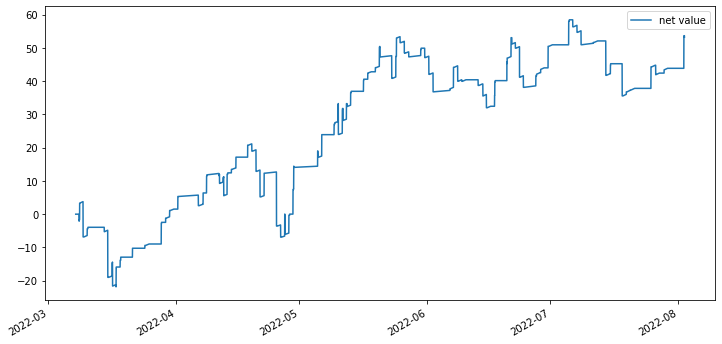

In [17]:
df_nv_full.loc[df_nv_full.index[0]:df_trade.index[1]] = [0]
df_nv_full.plot(figsize=(12,6))

In [18]:
# df_nv_full

In [19]:
# df_nv_full['return'] = df_nv_full['net value'].pct_change()
# df_nv_full

In [20]:
# df_nv_full.loc[df_trade.index[1]:].plot(figsize=(12,6))

In [21]:
# balance_final = df_trade['balance'].values[-1] - df_trade['commission'].sum() + df_trade['tax'].sum()
# balance_final
# df_balance = df_trade[['balance']].iloc[1:]
# df_balance['time'] = df_balance.index
# df_tmp = df_signal[['diff']]
# df_tmp['time'] = df_tmp.index
# # df_signal['time'] = df_signal.index
# df_balance_full =  pd.merge(df_balance,df_tmp,how='outer').sort_values(by='time').fillna(method='bfill')
# df_balance_full.index = df_tmp.index
# df_balance_full = df_balance_full[['balance']]
# # df_signal
# df_balance_full.loc[df_trade.index[2]:].plot(figsize=(12,6))